#### Task: Craigslist Vehicle Price Prediction

- Prasham Sheth(pds2136)
- Manas Dresswala(mad2306)

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import graphviz

from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV,KFold
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.compose import make_column_transformer,ColumnTransformer,make_column_selector
from sklearn.preprocessing import StandardScaler,OneHotEncoder,PolynomialFeatures
from category_encoders import TargetEncoder
from sklearn.feature_selection import RFECV,SelectFromModel
from sklearn.metrics import r2_score
from mlxtend.feature_selection import SequentialFeatureSelector

from sklearn.linear_model import LinearRegression,Ridge,Lasso,ElasticNet,SGDRegressor,RidgeCV,LassoCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

In [3]:
path = "C:\\Users\\sheth\\Desktop\\my stuff\\Columbia\\Semester 2\\Applied Machine Learning\\HW\\Submissions\\3\\"
data = pd.read_csv(path + "vehicles.csv")

In [4]:
data.shape

(509577, 25)

In [5]:
data.head()

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,...,drive,size,type,paint_color,image_url,description,county,state,lat,long
0,7034441763,https://saltlakecity.craigslist.org/cto/d/salt...,salt lake city,https://saltlakecity.craigslist.org,17899,2012.0,volkswagen,golf r,excellent,4 cylinders,...,4wd,compact,hatchback,black,https://images.craigslist.org/00G0G_fTLDWM5Xyv...,PRICE REDUCED! -Garage kept -Low Miles (63K)...,NaN,ut,40.7372,-111.858
1,7034440610,https://saltlakecity.craigslist.org/ctd/d/sand...,salt lake city,https://saltlakecity.craigslist.org,0,2016.0,ford,f-150,excellent,NaN,...,4wd,NaN,NaN,NaN,https://images.craigslist.org/00v0v_7Cu0buIofU...,Drive it home today. Call (Or Text) us now !!C...,NaN,ut,40.5881,-111.884
2,7034440588,https://saltlakecity.craigslist.org/ctd/d/sand...,salt lake city,https://saltlakecity.craigslist.org,46463,2015.0,gmc,sierra 1500,excellent,NaN,...,4wd,NaN,NaN,white,https://images.craigslist.org/01515_lPvJ9bfbdY...,Drive it home today. Call (Or Text) us now !!C...,NaN,ut,40.5881,-111.884
3,7034440546,https://saltlakecity.craigslist.org/ctd/d/sand...,salt lake city,https://saltlakecity.craigslist.org,0,2016.0,ford,f-150,excellent,NaN,...,4wd,NaN,NaN,NaN,https://images.craigslist.org/00T0T_6Rjfp3NS4O...,Drive it home today. Call (Or Text) us now !!C...,NaN,ut,40.5881,-111.884
4,7034406932,https://saltlakecity.craigslist.org/ctd/d/evan...,salt lake city,https://saltlakecity.craigslist.org,49999,2018.0,ford,f-450,NaN,NaN,...,4wd,NaN,pickup,white,https://images.craigslist.org/00W0W_8yIUwRBXXd...,2018 Ford F-350 F350 F 350 SD Lariat Crew Cab ...,NaN,ut,40.3744,-104.694


In [6]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 509577 entries, 0 to 509576
Data columns (total 25 columns):
id              509577 non-null int64
url             509577 non-null object
region          509577 non-null object
region_url      509577 non-null object
price           509577 non-null int64
year            508050 non-null float64
manufacturer    486813 non-null object
model           501588 non-null object
condition       277643 non-null object
cylinders       309894 non-null object
fuel            505592 non-null object
odometer        417253 non-null float64
title_status    506515 non-null object
transmission    505858 non-null object
vin             302152 non-null object
drive           365434 non-null object
size            167574 non-null object
type            368046 non-null object
paint_color     344871 non-null object
image_url       509563 non-null object
description     509561 non-null object
county          0 non-null float64
state           509577 non-null obj

In [163]:
data.nunique(axis=0)

id              509577
url             509577
region             403
region_url         413
price            17854
year               114
manufacturer        43
model            35852
condition            6
cylinders            8
fuel                 5
odometer        119873
title_status         6
transmission         3
vin             180145
drive                3
size                 4
type                13
paint_color         12
image_url       349468
description     427803
county               0
state               51
lat              51488
long             51467
dtype: int64

In [164]:
data.isnull().sum()

id                   0
url                  0
region               0
region_url           0
price                0
year              1527
manufacturer     22764
model             7989
condition       231934
cylinders       199683
fuel              3985
odometer         92324
title_status      3062
transmission      3719
vin             207425
drive           144143
size            342003
type            141531
paint_color     164706
image_url           14
description         16
county          509577
state                0
lat              10292
long             10292
dtype: int64

- We here have columns that have different kinds of strings which are used for representing the information in them. We have URL and Region URL which contain the craigslist region and the url for that region. 
- We also, have ID and VIN which uniquely represent the listing as VIN is the Vehicle Identification Number which is unique for each of the vehicle and ID represent the ID generated for each of the listing.
- Similar to Region URL we have Image URL which represents the URL for the images.
- There is a description field which describes the listed vehicle.
- We have the County column which is useless and has been left by mistake and has all of the values missing.
- We also have Latitude and Longitude, State, Region which decribes the location of the listing.

Using the above information we drop ID, URL, Region_URL, Image_URL, Description, County. We also drop Latitude and Longitude as State and Region are enough for us to know the trends over the given state and region. Using Latitude and Longitude would be overdoing the task as it then would be getting to know the trends for each of the particular location.

In [165]:
data.columns

Index(['id', 'url', 'region', 'region_url', 'price', 'year', 'manufacturer',
       'model', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status',
       'transmission', 'vin', 'drive', 'size', 'type', 'paint_color',
       'image_url', 'description', 'county', 'state', 'lat', 'long'],
      dtype='object')

In [166]:
data = data.drop(columns=["id","url","region_url","vin","image_url","description","county","lat","long"])

In [167]:
data.columns

Index(['region', 'price', 'year', 'manufacturer', 'model', 'condition',
       'cylinders', 'fuel', 'odometer', 'title_status', 'transmission',
       'drive', 'size', 'type', 'paint_color', 'state'],
      dtype='object')

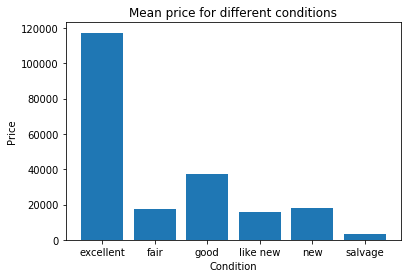

In [168]:
# understanding the mean price by condition
vehicles_by_condition = data.groupby('condition').mean()
vehicles_by_condition = vehicles_by_condition.reset_index()
vehicles_by_condition = vehicles_by_condition[['condition', 'price']]
plt.bar(vehicles_by_condition['condition'], vehicles_by_condition['price'])
plt.xlabel('Condition')
plt.ylabel('Price')
plt.title('Mean price for different conditions')
plt.show()

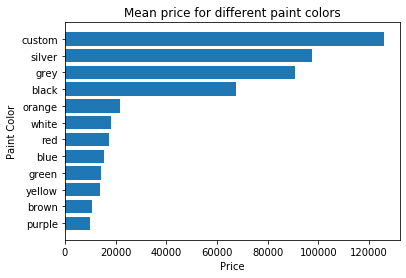

In [169]:
# understanding the mean price by paint color
vehicles_by_paint_color = data.groupby('paint_color').mean()
vehicles_by_paint_color = vehicles_by_paint_color.reset_index()
vehicles_by_paint_color = vehicles_by_paint_color[['paint_color', 'price']]
vehicles_by_paint_color = vehicles_by_paint_color.sort_values('price').reset_index(drop = True)
plt.barh(vehicles_by_paint_color['paint_color'], vehicles_by_paint_color['price'])
plt.ylabel('Paint Color')
plt.xlabel('Price')
plt.title('Mean price for different paint colors')
plt.show()

We further analyze the missing data in the columns and remove all the columns which have more than 40% of the data missing. This results in dropping the "condition", "Cylinders" and "size" column

In [170]:
missing = data.isnull().sum()

In [171]:
def filter_missing(missing,data,threshold = .4):
    col_pass = []
    for i in missing.keys():
        if missing[i]/data.shape[0]<threshold:
            col_pass.append(i)
    return col_pass

In [172]:
data = data[filter_missing(missing,data)]

In [173]:
data.columns

Index(['region', 'price', 'year', 'manufacturer', 'model', 'cylinders', 'fuel',
       'odometer', 'title_status', 'transmission', 'drive', 'type',
       'paint_color', 'state'],
      dtype='object')

In [174]:
data.shape

(509577, 14)

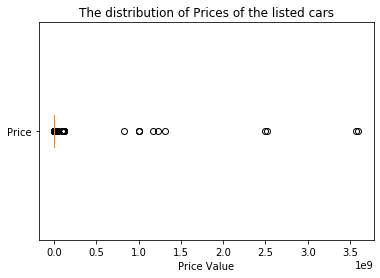

In [175]:
plt.boxplot(data["price"],vert=False)
plt.yticks([1],["Price"])
plt.xlabel("Price Value")
plt.title("The distribution of Prices of the listed cars")
plt.show()

The boxplot shows that there are many outlier points for the price column, as well as there are many points corresponding to 0 valued prices. Thus, we replace the ones with 0 price by the median of price columns. 

After replacing the 0 valued prices, we remove the ones which are outliers by considering the Interquantile Range.

In [176]:
data['price'] = data['price'].replace(0,data['price'].median())

In [177]:
price_desc = data['price'].describe()
price_iqr = price_desc["75%"] - price_desc["25%"]
price_iqr

12255.0

In [178]:
price_upper_limit = price_desc["75%"] + (1.5 * price_iqr)
price_lower_limit = price_desc["25%"] - (1.5 * price_iqr)

In [179]:
data = data[data["price"]<=price_upper_limit]
data = data[data["price"]>=price_lower_limit]
data.shape

(488479, 14)

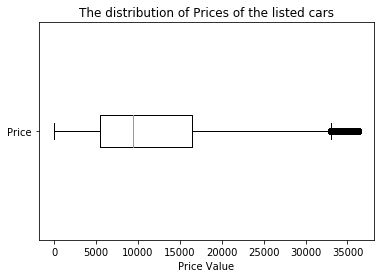

In [180]:
plt.boxplot(data["price"],vert=False)
plt.yticks([1],["Price"])
plt.xlabel("Price Value")
plt.title("The distribution of Prices of the listed cars")
plt.show()

Also, we have Odometer readings which seem to have many outlier points. We remove those as well by a similar logic considering the Interquantile Range.

In [181]:
odo_desc = data['odometer'].describe()
odo_iqr = odo_desc["75%"] - odo_desc["25%"]
odo_iqr

87343.0

In [182]:
odo_upper_limit = odo_desc["75%"] + (1.5 * odo_iqr)
odo_lower_limit = odo_desc["25%"] - (1.5 * odo_iqr)

In [183]:
data = data[data["price"]<=odo_upper_limit]
data = data[data["price"]>=odo_lower_limit]
data.shape

(488479, 14)

We now remove all the rows with year greater than 2020 as we cannot have any years greater than 2020.

In [184]:
(data["year"]>2020).sum()

21

In [185]:
data = data[data["year"]<=2020]
data.shape

(487541, 14)

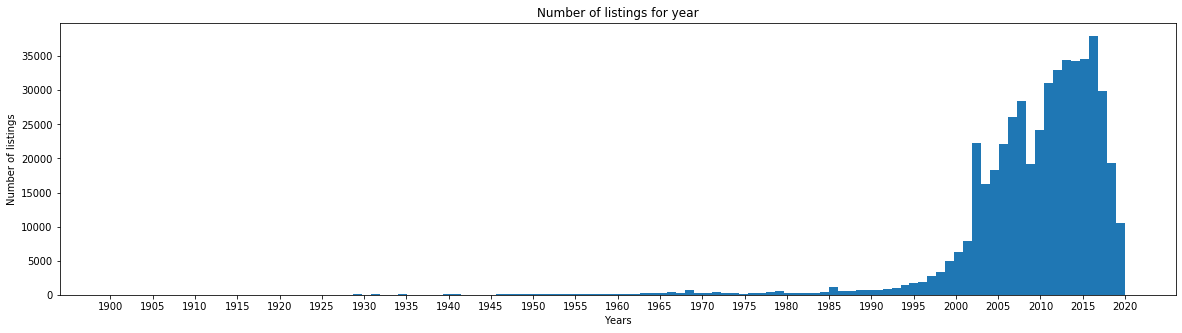

In [186]:
plt.figure(figsize=(20,5))
plt.hist(data["year"],bins=len(data["year"].unique()))
plt.xlabel("Years")
plt.xticks(np.arange(min(data["year"]), max(data["year"])+1, 5.0))
plt.ylabel("Number of listings")
plt.title("Number of listings for year")
plt.show()

Most the year values are after 1985. So, we only keep rows with year greater than 1985.

In [187]:
data = data[data["year"]>=1985]
data.shape

(478591, 14)

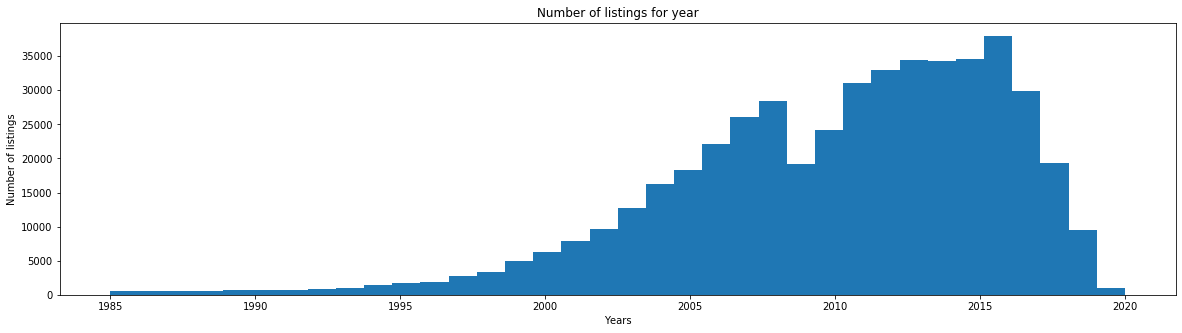

In [188]:
plt.figure(figsize=(20,5))
plt.hist(data["year"],bins=len(data["year"].unique()))
plt.xlabel("Years")
plt.xticks(np.arange(min(data["year"]), max(data["year"])+1, 5.0))
plt.ylabel("Number of listings")
plt.title("Number of listings for year")
plt.show()

Now that we have all the columns having more than 40% of the data missing, we now have two options to move forward.
1. Drop all the rows with missing values
2. Impute the missing values using some kind of imputation technique.

Further we classify each of the column into 3 categories:
1. The ones to be Target encoded
2. The ones that are Categorical and need to be one hot encoded
3. Continuous columns that are to be scaled
Note that Year doesn't belong to any of those being an ordinal feature

In [189]:
target_encoding_columns = ["region","state", 'model','manufacturer']
contiuous_columns_to_be_scaled = ["odometer"]
categorical_columns = ['cylinders', 'fuel','title_status', 'transmission', 
                       'drive', 'type','paint_color']

We decide to apply target encoding to four of the column: Region, State, Model, Manufacture. This is with a logic that we have an average price for each Region, each State, each Model and each Manufacturer.

The is a continuous column "Odometer" which we need to scale.

"Year" is an ordinal variable which we don't scale.

The rest of the columns are categorical which we One-Hot Encode

In [190]:
for i in categorical_columns:
    print(i + " has " + str(len(data[i].unique())) + " values")

cylinders has 9 values
fuel has 6 values
title_status has 7 values
transmission has 4 values
drive has 4 values
type has 14 values
paint_color has 13 values


#### 1. When we drop all the rows with missing values

In [191]:
data_dropped_NA = data.dropna()

In [192]:
data_dropped_NA.shape

(179492, 14)

Dropping the rows with NA values removes a lot of rows(almost 65% of the data) which would hamper the building of a generalizable model and hence, we shift to imputing missing values. We tried implmenting Regression Models but we then realised it wasn't possible to generalize and hence shifted to imputing missing values.

#### 2. When we drop all the rows with missing values

- We impute the columns "Model", "Manufacturer" and "Paint Color" with "UNK" when we have missing values.
- For the other columns, we impute the missing values with mean in case continuous columns and most repeting value in case of categorical columns.
- We fill the missing years with the most repeting year.

In [198]:
for i in data.drop(['year','model','manufacturer','paint_color'],axis=1).columns:
    if data[i].dtype=='float':
        data[i]=data[i].fillna(data[i].mean())
    if data[i].dtype=='object':
        data[i]=data[i].fillna(data[i].mode()[0])
data['year']=data['year'].fillna(data['year'].mode()[0])
data['model']=data['model'].fillna('UNK')
data['manufacturer']=data['manufacturer'].fillna('UNK')
data['paint_color']=data['paint_color'].fillna('UNK')

In [199]:
y = data["price"]
X = data.drop("price",axis=1)

### Basic Model (Using only Numeric Features)

In [200]:
X_1 = data[["year","odometer"]]
X_train_val, X_test, y_train_val, y_test = train_test_split(X_1, y, test_size=0.20, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.20, random_state=0)

In [201]:
only_scaling = make_pipeline(StandardScaler())
processing_pipe = make_column_transformer((only_scaling, contiuous_columns_to_be_scaled),
                                         remainder="passthrough")
pipe = Pipeline([('preprocess', processing_pipe),
                 ('regression', LinearRegression())])

In [202]:
score = cross_val_score(pipe, X_train_val, y_train_val, cv=5,scoring="neg_mean_squared_error")
np.mean(score)

-49460855.33777468

In [203]:
score = cross_val_score(pipe, X_train_val, y_train_val, cv=5)
np.mean(score)

0.27327886701233817

In [204]:
param_grid_ridge = [{'regressor__alpha': np.logspace(-5, 3, 15)}]
param_grid_lasso = [{'regressor__alpha': np.logspace(-5, 3, 15)}]
param_grid_elastic = [{'regressor__l1_ratio':np.logspace(-5,1,15)}]

In [205]:
pipe = Pipeline([('preprocess', processing_pipe),
                 ('regressor', Ridge())])
grid_ridge = GridSearchCV(pipe, param_grid_ridge)
grid_ridge.fit(X_train_val, y_train_val)
best_score = grid_ridge.score(X_test, y_test)
best_score

0.26591221124207476

In [206]:
pipe = Pipeline([('preprocess', processing_pipe),
                 ('regressor', Lasso())])
grid_lasso = GridSearchCV(pipe, param_grid_lasso)
grid_lasso.fit(X_train_val, y_train_val)
best_score = grid_lasso.score(X_test, y_test)
best_score

0.2659328229818777

In [207]:
pipe = Pipeline([('preprocess', processing_pipe),
                 ('regressor', ElasticNet())])
grid_elastic = GridSearchCV(pipe, param_grid_elastic)
grid_elastic.fit(X_train_val, y_train_val)
best_score = grid_elastic.score(X_test, y_test)
best_score

0.2663595813159447

### Using categorical Features along with Numerical ones

Making a pipeline for preprocessing categorical features and continous features

In [208]:
target_scaling = make_pipeline(TargetEncoder(), StandardScaler())
only_scaling = make_pipeline(StandardScaler())
categorical_onehot = make_pipeline(OneHotEncoder(handle_unknown="ignore"))
processing_pipe = make_column_transformer((target_scaling, target_encoding_columns),
                                          (only_scaling, contiuous_columns_to_be_scaled),
                                          (categorical_onehot,categorical_columns),
                                         remainder="passthrough")

### Regression Models for whole Dataset

In [209]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.20, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.20, random_state=0)

In [210]:
pipe = Pipeline([('preprocess', processing_pipe),
                 ('regression', LinearRegression())])
score = cross_val_score(pipe, X_train_val, y_train_val, cv=5,scoring="neg_mean_squared_error")
np.mean(score)

-28827782.404364668

In [211]:
pipe = Pipeline([('preprocess', processing_pipe),
                 ('regression', LinearRegression())])
score = cross_val_score(pipe, X_train_val, y_train_val, cv=5)
np.mean(score)

0.5764384588232787

From the Linear Regression model, we can say that it takes a lot of time to learn the model given the data size and cross validating it even takes more time. 

Thus we use sample size of 10,20,30,40 and 50% to find the best models out of the following ones and then tune the best model by implementing a grid search over different hyperparameters.
1. Linear Regression
2. Stochastic Gradient Descent Regressor
3. Decision Tree 
4. Gradient Boosting Regression
5. XGBoost Regression
6. Random Forest

- For Gradient Boosting Regression, we implement two versions (one with maximum depth of 5 and another with maximum depth of 7)
- For XGBoost model also, we implement 2 versions. 1 with the deafult setting of hyperparameters and another with randomly decided setting

## Subsample (10%)

In [212]:
# randomly subsampling 
sample1 = data.sample(frac=0.1, random_state=1)
print(sample1.shape)
y = sample1[['price']] # label
X = sample1.drop(columns = ['price']) # features

(47859, 14)


In [213]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.20, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.20, random_state=0)

In [214]:
pipe = Pipeline([('preprocess', processing_pipe),
                 ('regression', LinearRegression())])
score = cross_val_score(pipe, X_train_val, y_train_val, cv=5,scoring="neg_mean_squared_error")
np.mean(score)

-32781083.558821786

In [215]:
pipe = Pipeline([('preprocess', processing_pipe),
                 ('regression', LinearRegression())])
score = cross_val_score(pipe, X_train_val, y_train_val, cv=5)
np.mean(score)

0.5211285876721928

In [216]:
# Stochastic Gradient Descent 
pipe = make_pipeline(processing_pipe, SGDRegressor())
score = cross_val_score(pipe, X_train_val, y_train_val, cv = 5)
print(np.mean(score))

-7.358670158813135e+21


In [217]:
# Decision Tree 
pipe = make_pipeline(processing_pipe, DecisionTreeRegressor(max_depth = 7))
score = cross_val_score(pipe, X_train_val, y_train_val, cv = 5)
print(np.mean(score))

0.5539711811226231


In [218]:
# Gradient Boosting Regression
pipe = make_pipeline(processing_pipe, GradientBoostingRegressor(max_depth = 5))
score = cross_val_score(pipe, X_train_val, y_train_val, cv = 5)
print(np.mean(score))

0.6462138376125792


In [219]:
# Gradient Boosting Regression
pipe = make_pipeline(processing_pipe, GradientBoostingRegressor(max_depth = 7))
score = cross_val_score(pipe, X_train_val, y_train_val, cv = 5)
print(np.mean(score))

0.6649037412907189


In [220]:
# XGBoost Regression
xg_reg = XGBRegressor()
pipe = make_pipeline(processing_pipe, xg_reg)
score = cross_val_score(pipe, X_train_val, y_train_val, cv = 5)
print(np.mean(score))

0.6692412624682891


In [221]:
xg_reg = XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 50, alpha = 10, n_estimators = 50)
pipe = make_pipeline(processing_pipe, xg_reg)
score = cross_val_score(pipe, X_train_val, y_train_val, cv = 5)
print(np.mean(score))

0.6758496580181348


In [222]:
# Random Forest
pipe = make_pipeline(processing_pipe, RandomForestRegressor(max_depth = 7))
score = cross_val_score(pipe, X_train_val, y_train_val, cv = 5)
print(np.mean(score))

0.5799041778086282


## SubSample (20%)

In [223]:
# randomly subsampling 
sample1 = data.sample(frac=0.2, random_state=1)
print(sample1.shape)
# splitting the data into X (features) and y (i.e. label)
y = sample1[['price']] # label
X = sample1.drop(columns = ['price']) # features

(95718, 14)


In [224]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.20, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.20, random_state=0)

In [225]:
pipe = Pipeline([('preprocess', processing_pipe),
                 ('regression', LinearRegression())])
score = cross_val_score(pipe, X_train_val, y_train_val, cv=5,scoring="neg_mean_squared_error")
np.mean(score)

-31131057.526327483

In [226]:
pipe = Pipeline([('preprocess', processing_pipe),
                 ('regression', LinearRegression())])
score = cross_val_score(pipe, X_train_val, y_train_val, cv=5)
np.mean(score)

0.541863657346782

In [227]:
# Stochastic Gradient Descent 
pipe = make_pipeline(processing_pipe, SGDRegressor())
score = cross_val_score(pipe, X_train_val, y_train_val, cv = 5)
print(np.mean(score))

-4.524949085033409e+21


In [228]:
# Decision Tree 
pipe = make_pipeline(processing_pipe, DecisionTreeRegressor(max_depth = 7))
score = cross_val_score(pipe, X_train_val, y_train_val, cv = 5)
print(np.mean(score))

0.5764613542344728


In [229]:
# Gradient Boosting Regression
pipe = make_pipeline(processing_pipe, GradientBoostingRegressor(max_depth = 5))
score = cross_val_score(pipe, X_train_val, y_train_val, cv = 5)
print(np.mean(score))

0.6648161704960778


In [230]:
# Gradient Boosting Regression
pipe = make_pipeline(processing_pipe, GradientBoostingRegressor(max_depth = 7))
score = cross_val_score(pipe, X_train_val, y_train_val, cv = 5)
print(np.mean(score))

0.6884142902653357


In [231]:
xg_reg = XGBRegressor()
pipe = make_pipeline(processing_pipe, xg_reg)
score = cross_val_score(pipe, X_train_val, y_train_val, cv = 5)
print(np.mean(score))

0.6978206659765077


In [232]:
xg_reg = XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 50, alpha = 10, n_estimators = 50)
pipe = make_pipeline(processing_pipe, xg_reg)
score = cross_val_score(pipe, X_train_val, y_train_val, cv = 5)
print(np.mean(score))

0.718828636692471


In [233]:
pipe = make_pipeline(processing_pipe, RandomForestRegressor(max_depth = 7))
score = cross_val_score(pipe, X_train_val, y_train_val, cv = 5)
print(np.mean(score))

0.6006666006330691


## SubSample (30%)

In [234]:
# randomly subsampling 
sample1 = data.sample(frac=0.3, random_state=1)
print(sample1.shape)
# splitting the data into X (features) and y (i.e. label)
y = sample1[['price']] # label
X = sample1.drop(columns = ['price']) # features

(143577, 14)


In [235]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.20, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.20, random_state=0)

In [236]:
pipe = Pipeline([('preprocess', processing_pipe),
                 ('regression', LinearRegression())])
score = cross_val_score(pipe, X_train_val, y_train_val, cv=5,scoring="neg_mean_squared_error")
np.mean(score)

-30698839.69322101

In [237]:
pipe = Pipeline([('preprocess', processing_pipe),
                 ('regression', LinearRegression())])
score = cross_val_score(pipe, X_train_val, y_train_val, cv=5)
np.mean(score)

0.5510097801886962

In [238]:
# Stochastic Gradient Descent 
pipe = make_pipeline(processing_pipe, SGDRegressor())
score = cross_val_score(pipe, X_train_val, y_train_val, cv = 5)
print(np.mean(score))

-8.541830391687783e+20


In [239]:
# Decision Tree 
pipe = make_pipeline(processing_pipe, DecisionTreeRegressor(max_depth = 7))
score = cross_val_score(pipe, X_train_val, y_train_val, cv = 5)
print(np.mean(score))

0.5914990852878315


In [240]:
# Gradient Boosting Regression
pipe = make_pipeline(processing_pipe, GradientBoostingRegressor(max_depth = 5))
score = cross_val_score(pipe, X_train_val, y_train_val, cv = 5)
print(np.mean(score))

0.67318829600755


In [241]:
# Gradient Boosting Regression
pipe = make_pipeline(processing_pipe, GradientBoostingRegressor(max_depth = 7))
score = cross_val_score(pipe, X_train_val, y_train_val, cv = 5)
print(np.mean(score))

0.7006597090391571


In [242]:
xg_reg = XGBRegressor()
pipe = make_pipeline(processing_pipe, xg_reg)
score = cross_val_score(pipe, X_train_val, y_train_val, cv = 5)
print(np.mean(score))

0.7093630934072545


In [243]:
xg_reg = XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 50, alpha = 10, n_estimators = 50)
pipe = make_pipeline(processing_pipe, xg_reg)
score = cross_val_score(pipe, X_train_val, y_train_val, cv = 5)
print(np.mean(score))

0.7455221386449707


In [244]:
pipe = make_pipeline(processing_pipe, RandomForestRegressor(max_depth = 7))
score = cross_val_score(pipe, X_train_val, y_train_val, cv = 5)
print(np.mean(score))

0.6089095954268211


## SubSample (40%)

In [245]:
# randomly subsampling 
sample1 = data.sample(frac=0.4, random_state=1)
print(sample1.shape)
# splitting the data into X (features) and y (i.e. label)
y = sample1[['price']] # label
X = sample1.drop(columns = ['price']) # features

(191436, 14)


In [246]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.20, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.20, random_state=0)

In [247]:
pipe = Pipeline([('preprocess', processing_pipe),
                 ('regression', LinearRegression())])
score = cross_val_score(pipe, X_train_val, y_train_val, cv=5,scoring="neg_mean_squared_error")
np.mean(score)

-29999275.226758145

In [248]:
pipe = Pipeline([('preprocess', processing_pipe),
                 ('regression', LinearRegression())])
score = cross_val_score(pipe, X_train_val, y_train_val, cv=5)
np.mean(score)

0.5597775158656985

In [249]:
# Stochastic Gradient Descent 
pipe = make_pipeline(processing_pipe, SGDRegressor())
score = cross_val_score(pipe, X_train_val, y_train_val, cv = 5)
print(np.mean(score))

-2.8515804004805714e+21


In [250]:
# Decision Tree 
pipe = make_pipeline(processing_pipe, DecisionTreeRegressor(max_depth = 7))
score = cross_val_score(pipe, X_train_val, y_train_val, cv = 5)
print(np.mean(score))

0.5940618660796189


In [251]:
# Gradient Boosting Regression
pipe = make_pipeline(processing_pipe, GradientBoostingRegressor(max_depth = 5))
score = cross_val_score(pipe, X_train_val, y_train_val, cv = 5)
print(np.mean(score))

0.679237164237456


In [252]:
# Gradient Boosting Regression
pipe = make_pipeline(processing_pipe, GradientBoostingRegressor(max_depth = 7))
score = cross_val_score(pipe, X_train_val, y_train_val, cv = 5)
print(np.mean(score))

0.7060943509181318


In [253]:
xg_reg = XGBRegressor()
pipe = make_pipeline(processing_pipe, xg_reg)
score = cross_val_score(pipe, X_train_val, y_train_val, cv = 5)
print(np.mean(score))

0.719536922417604


In [254]:
xg_reg = XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 50, alpha = 10, n_estimators = 50)
pipe = make_pipeline(processing_pipe, xg_reg)
score = cross_val_score(pipe, X_train_val, y_train_val, cv = 5)
print(np.mean(score))

0.7624377944004194


In [255]:
pipe = make_pipeline(processing_pipe, RandomForestRegressor(max_depth = 7))
score = cross_val_score(pipe, X_train_val, y_train_val, cv = 5)
print(np.mean(score))

0.6120525932639855


## SubSample(50%)

In [256]:
# randomly subsampling 
sample1 = data.sample(frac=0.5, random_state=1)
print(sample1.shape)
# splitting the data into X (features) and y (i.e. label)
y = sample1[['price']] # label
X = sample1.drop(columns = ['price']) # features

(239296, 14)


In [257]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.20, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.20, random_state=0)

In [258]:
pipe = Pipeline([('preprocess', processing_pipe),
                 ('regression', LinearRegression())])
score = cross_val_score(pipe, X_train_val, y_train_val, cv=5,scoring="neg_mean_squared_error")
np.mean(score)

-29787843.359199416

In [259]:
pipe = Pipeline([('preprocess', processing_pipe),
                 ('regression', LinearRegression())])
score = cross_val_score(pipe, X_train_val, y_train_val, cv=5)
np.mean(score)

0.5623631037731954

In [260]:
# Stochastic Gradient Descent 
pipe = make_pipeline(processing_pipe, SGDRegressor())
score = cross_val_score(pipe, X_train_val, y_train_val, cv = 5)
print(np.mean(score))

-1.667744883474543e+21


In [261]:
# Decision Tree 
pipe = make_pipeline(processing_pipe, DecisionTreeRegressor(max_depth = 7))
score = cross_val_score(pipe, X_train_val, y_train_val, cv = 5)
print(np.mean(score))

0.6013040178942486


In [262]:
# Gradient Boosting Regression
pipe = make_pipeline(processing_pipe, GradientBoostingRegressor(max_depth = 5))
score = cross_val_score(pipe, X_train_val, y_train_val, cv = 5)
print(np.mean(score))

0.6834660521485982


In [263]:
# Gradient Boosting Regression
pipe = make_pipeline(processing_pipe, GradientBoostingRegressor(max_depth = 7))
score = cross_val_score(pipe, X_train_val, y_train_val, cv = 5)
print(np.mean(score))

0.7128378647542968


In [264]:
pipe = make_pipeline(processing_pipe, XGBRegressor())
score = cross_val_score(pipe, X_train_val, y_train_val, cv = 5)
print(np.mean(score))

0.7252728091432268


In [265]:
xg_reg = XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 50, alpha = 10, n_estimators = 50)
pipe = make_pipeline(processing_pipe, xg_reg)
score = cross_val_score(pipe, X_train_val, y_train_val, cv = 5)
print(np.mean(score))

0.7760494415971942


In [266]:
pipe = make_pipeline(processing_pipe, RandomForestRegressor(max_depth = 7))
score = cross_val_score(pipe, X_train_val, y_train_val, cv = 5)
print(np.mean(score))

0.6166072853154958


From the performance of each model for each of the different subsamples we can see that XGBoost Regressor performance the best in all cases and hence, we tune the hyperparameters of the XGBoost model

# Output Graphs of different models

In [3]:
models = ['Linear Regression', 'Decision Tree', 'Gradient Boosting', 'XGBoost', 'Random Forest']
s1 = [0.5211285876721928, 0.5539711811226231, 0.6649037412907189, 0.6758496580181348, 0.5799041778086282]
s2 = [0.541863657346782, 0.5764613542344728, 0.6884142902653357, 0.718828636692471, 0.6006666006330691]
s3 = [0.5510097801886962, 0.5914990852878315, 0.7006597090391571, 0.7455221386449707, 0.6089095954268211]
s4 = [0.5597775158656985, 0.5940618660796189, 0.7060943509181318, 0.7624377944004194, 0.6120525932639855]
s5 = [0.5623631037731954, 0.6013040178942486, 0.7128378647542968, 0.7760494415971942, 0.6166072853154958]

In [4]:
r2_scores = dict()
r2_scores['Sample 1 (10%)'] = s1
r2_scores['Sample 2 (20%)'] = s2
r2_scores['Sample 3 (30%)'] = s3
r2_scores['Sample 4 (40%)'] = s4
r2_scores['Sample 5 (50%)'] = s5

r2_scores_df = pd.DataFrame(r2_scores)
r2_scores_df.index = models
r2_scores_df

,Sample 1 (10%),Sample 2 (20%),Sample 3 (30%),Sample 4 (40%),Sample 5 (50%)
Linear Regression,0.521129,0.541864,0.551010,0.559778,0.562363
Decision Tree,0.553971,0.576461,0.591499,0.594062,0.601304
Gradient Boosting,0.664904,0.688414,0.700660,0.706094,0.712838
XGBoost,0.675850,0.718829,0.745522,0.762438,0.776049
Random Forest,0.579904,0.600667,0.608910,0.612053,0.616607


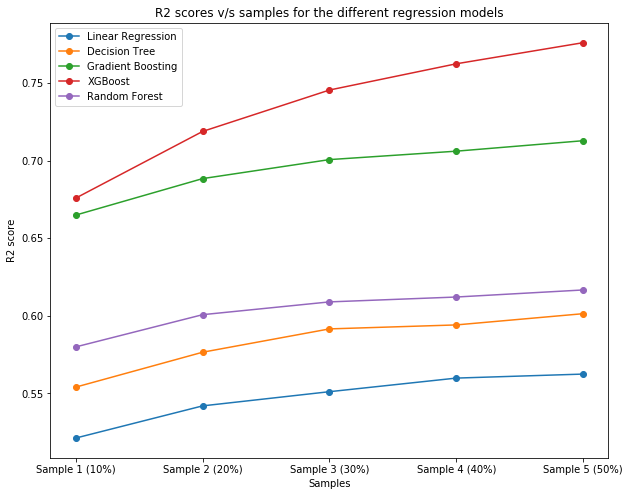

In [5]:
plt.figure(figsize=(10,8))
for i in models:
    plt.plot(r2_scores_df.loc[i], label = i, marker='o')
plt.legend(loc='upper left')
plt.xlabel("Samples")
plt.ylabel("R2 score")
plt.title("R2 scores v/s samples for the different regression models")
plt.show()

Seeing the size of the dataset we decided to implement the grid search over the 50% sample and then use the obtained setting to train XGBoost model for whole dataset.

In [66]:
params = [{'XGBRegressor__max_depth':[10,25,50],
           'XGBRegressor__colsample_bytree' : [0.2,0.3,0.4,0.5,0.6], 
           'XGBRegressor__learning_rate': [1,0.1,0.01,0.001],
           'XGBRegressor__n_jobs': [-1],
           'XGBRegressor__n_estimators':[30, 50],
           'XGBRegressor__alpha': [0.1,1,10]
          }]

pipe = Pipeline([('preprocess', processing_pipe),
                 ('XGBRegressor', XGBRegressor())])
grid_xgb = GridSearchCV(pipe, params)
grid_xgb.fit(X_train_val, y_train_val)
best_score = grid_xgb.score(X_test, y_test)
best_score

0.799503702863626

In [70]:
from sklearn.externals import joblib
joblib.dump(grid_xgb.best_estimator_, 'XGB.pkl')

['XGB.pkl']

In [71]:
grid_xgb.best_params_

{'XGBRegressor__alpha': 0.1,
 'XGBRegressor__colsample_bytree': 0.5,
 'XGBRegressor__learning_rate': 0.1,
 'XGBRegressor__max_depth': 25,
 'XGBRegressor__n_estimators': 50,
 'XGBRegressor__n_jobs': -1}

## XGBoost for whole Dataset

In [267]:
sample1 = data.sample(frac=1, random_state=1)
y = sample1[['price']] # label
X = sample1.drop(columns = ['price'])

In [268]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.20, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.20, random_state=0)

In [269]:
xg_reg = XGBRegressor()
pipe = make_pipeline(processing_pipe, xg_reg)
score = cross_val_score(pipe, X_train_val, y_train_val, cv = 5)
print(np.mean(score))

0.7354529263853505


In [270]:
xg_reg = XGBRegressor(colsample_bytree = 0.3, 
                          learning_rate = 0.1,
                          max_depth = 50, 
                          alpha = 10, 
                          n_estimators = 50)
pipe = make_pipeline(processing_pipe, xg_reg)
score = cross_val_score(pipe, X_train_val, y_train_val, cv = 5)
print(np.mean(score))

0.8146652253524929


In [271]:
xg_reg = XGBRegressor(alpha=0.1,
                          colsample_bytree = 0.5,
                          learning_rate=0.1,
                          max_depth = 25,
                          n_estimators = 50,
                          n_jobs=-1)
pipe = make_pipeline(processing_pipe, xg_reg)
score = cross_val_score(pipe, X_train_val, y_train_val, cv = 5)
print(np.mean(score))


# {'XGBRegressor__alpha': 0.1,
#  'XGBRegressor__colsample_bytree': 0.5,
#  'XGBRegressor__learning_rate': 0.1,
#  'XGBRegressor__max_depth': 25,
#  'XGBRegressor__n_estimators': 50,
#  'XGBRegressor__n_jobs': -1}

0.8226768467326991


As, we can see from the above results that XGBoost model performs the best with the obtained seeting of hyperparameters.

We also train linear models (Linear Regression, Ridge Regression and Lasso Regression) over the whole dataset to compare their performance with XGBoost.

In [48]:
param_grid_ridge = [{'regressor__alpha': np.logspace(-5, 3, 15)}]
param_grid_lasso = [{'regressor__alpha': np.logspace(-5, 3, 15)}]
param_grid_elastic = [{'regressor__l1_ratio':np.logspace(-5,1,15)}]

In [49]:
pipe = Pipeline([('preprocess', processing_pipe),
                 ('regressor', Ridge())])
grid_ridge = GridSearchCV(pipe, param_grid_ridge)
grid_ridge.fit(X_train_val, y_train_val)
best_score = grid_ridge.score(X_test, y_test)
best_score

0.44432382468913034

In [50]:
pipe = Pipeline([('preprocess', processing_pipe),
                 ('regressor', Lasso())])
grid_lasso = GridSearchCV(pipe, param_grid_lasso)
grid_lasso.fit(X_train_val, y_train_val)
best_score = grid_lasso.score(X_test, y_test)
best_score

0.577326601015952

In [51]:
pipe = Pipeline([('preprocess', processing_pipe),
                 ('regressor', ElasticNet())])
grid_elastic = GridSearchCV(pipe, param_grid_elastic)
grid_elastic.fit(X_train_val, y_train_val)
best_score = grid_elastic.score(X_test, y_test)
best_score

0.5419882937501296

From, this we see that the XGBoost model performs much better than the Linear Models. Hence, we now move towards getting a score for XGBoost model over the test dataset. Also the training and prediction time for the XGBoost model is very less as compared to all of the other models tried earlier.

In [272]:
xg_reg = XGBRegressor(alpha=0.1,
                          colsample_bytree = 0.5,
                          learning_rate=0.1,
                          max_depth = 25,
                          n_estimators = 50,
                          n_jobs=-1)
pipe = make_pipeline(processing_pipe, xg_reg)


In [274]:
start_time = time.time()
pipe.fit(X_train_val, y_train_val)
# pred = pipe.predict(X_test)
print(pipe.score(X_test,y_test))
print("--- %s seconds ---" % (time.time() - start_time))

0.8336336456915
--- 77.34524989128113 seconds ---


Further XGBoost being a tree based model we can use the feature_importances_ attribute of it to find the importance given to the features by the model.

# Feature Importance and Feature Selection

### Feature Importance for Random Forest Regressor 
#### Over 50% randomly sampled data points

In [11]:
# randomly subsampling 
sample5 = data.sample(frac=0.5, random_state=1)
print(sample5.shape)

# splitting the data into X (features) and y (i.e. label)
y = sample5[['price']] # label
X = sample5.drop(columns = ['price']) # features

# preprocess the data - 
# for categorical data using OneHotEncoder and/or TargetEncoder
# for continuous data using StandardScaler
categorical = X.dtypes == object

target_encoding_columns = ["region", 'model', 'manufacturer']
contiuous_columns_to_be_scaled = ["odometer"]
categorical_columns = ['cylinders', 'fuel','title_status', 'transmission', 
                       'drive', 'type','paint_color']

preprocess = make_column_transformer(
    (StandardScaler(), contiuous_columns_to_be_scaled),
    (OneHotEncoder(handle_unknown = 'ignore'), categorical_columns),
    (TargetEncoder(), target_encoding_columns), remainder="passthrough")

# splitting the data into training, validation and testing
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state = 42)

(242064, 13)


In [12]:
# converting y to numpy for random forest regression
y_train_val = y_train_val.values
y_train_val = y_train_val.ravel()
# pipeline for Random Forest Regression
pipe = make_pipeline(preprocess, RandomForestRegressor(max_depth = 7))

In [13]:
start_time = time.time()
pipe.fit(X_train_val, y_train_val)
pred = pipe.predict(X_test)
print(pipe.score(X_test,y_test))
print("--- %s seconds ---" % (time.time() - start_time))

0.6263911002615566
--- 454.1613118648529 seconds ---


In [15]:
n1 = list(np.hstack([preprocess.named_transformers_['onehotencoder'].get_feature_names(), categorical_columns]))
n2 = list(np.hstack([preprocess.named_transformers_['targetencoder'].get_feature_names(), target_encoding_columns]))
print(n1)
print(n2)

['x0_10 cylinders', 'x0_12 cylinders', 'x0_3 cylinders', 'x0_4 cylinders', 'x0_5 cylinders', 'x0_6 cylinders', 'x0_8 cylinders', 'x0_other', 'x1_diesel', 'x1_electric', 'x1_gas', 'x1_hybrid', 'x1_other', 'x2_clean', 'x2_lien', 'x2_missing', 'x2_parts only', 'x2_rebuilt', 'x2_salvage', 'x3_automatic', 'x3_manual', 'x3_other', 'x4_4wd', 'x4_fwd', 'x4_rwd', 'x5_SUV', 'x5_bus', 'x5_convertible', 'x5_coupe', 'x5_hatchback', 'x5_mini-van', 'x5_offroad', 'x5_other', 'x5_pickup', 'x5_sedan', 'x5_truck', 'x5_van', 'x5_wagon', 'x6_Unknown', 'x6_black', 'x6_blue', 'x6_brown', 'x6_custom', 'x6_green', 'x6_grey', 'x6_orange', 'x6_purple', 'x6_red', 'x6_silver', 'x6_white', 'x6_yellow', 'cylinders', 'fuel', 'title_status', 'transmission', 'drive', 'type', 'paint_color']
['region', 'model', 'manufacturer', 'region', 'model', 'manufacturer']


In [17]:
n1 = n1[:51]
n2 = n2[:3]

In [1]:
n3 = ['odometer']
preprocess_cols = n3
preprocess_cols.extend(n1)
preprocess_cols.extend(n2)
preprocess_cols.append('year')

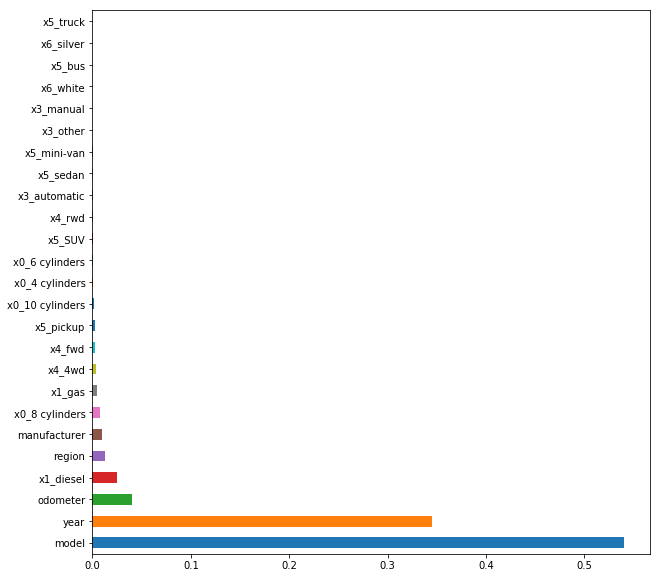

In [23]:
feat_importances = pd.Series(pipe[1].feature_importances_, preprocess_cols)
feat_importances.nlargest(25).plot(kind='barh',figsize=(10,10))

### Feature Importance for XGBoost Regressor

In [275]:
y_train_val = y_train_val.values
y_train_val = y_train_val.ravel()
xg_reg = XGBRegressor(alpha=0.1,
                          colsample_bytree = 0.5,
                          learning_rate=0.1,
                          max_depth = 25,
                          n_estimators = 50,
                          n_jobs=-1)
pipe = make_pipeline(processing_pipe, xg_reg)


In [276]:
start_time = time.time()
pipe.fit(X_train_val, y_train_val)
pred = pipe.predict(X_test)
print(pipe.score(X_test,y_test))
print("--- %s seconds ---" % (time.time() - start_time))

0.8336336456915
--- 78.51062154769897 seconds ---


In [277]:
n1 = list(np.hstack([processing_pipe.named_transformers_["pipeline-3"]["onehotencoder"].get_feature_names(), categorical_columns]))
n2 = list(np.hstack([processing_pipe.named_transformers_["pipeline-1"]['targetencoder'].get_feature_names(), target_encoding_columns]))
print(n1)
print(n2)

['x0_10 cylinders', 'x0_12 cylinders', 'x0_3 cylinders', 'x0_4 cylinders', 'x0_5 cylinders', 'x0_6 cylinders', 'x0_8 cylinders', 'x0_other', 'x1_diesel', 'x1_electric', 'x1_gas', 'x1_hybrid', 'x1_other', 'x2_clean', 'x2_lien', 'x2_missing', 'x2_parts only', 'x2_rebuilt', 'x2_salvage', 'x3_automatic', 'x3_manual', 'x3_other', 'x4_4wd', 'x4_fwd', 'x4_rwd', 'x5_SUV', 'x5_bus', 'x5_convertible', 'x5_coupe', 'x5_hatchback', 'x5_mini-van', 'x5_offroad', 'x5_other', 'x5_pickup', 'x5_sedan', 'x5_truck', 'x5_van', 'x5_wagon', 'x6_UNK', 'x6_black', 'x6_blue', 'x6_brown', 'x6_custom', 'x6_green', 'x6_grey', 'x6_orange', 'x6_purple', 'x6_red', 'x6_silver', 'x6_white', 'x6_yellow', 'cylinders', 'fuel', 'title_status', 'transmission', 'drive', 'type', 'paint_color']
['region', 'state', 'model', 'manufacturer', 'region', 'state', 'model', 'manufacturer']


In [278]:
processing_pipe

ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0.3,
                  transformer_weights=None,
                  transformers=[('pipeline-1',
                                 Pipeline(memory=None,
                                          steps=[('targetencoder',
                                                  TargetEncoder(cols=None,
                                                                drop_invariant=False,
                                                                handle_missing='value',
                                                                handle_unknown='value',
                                                                min_samples_leaf=1,
                                                                return_df=True,
                                                                smoothing=1.0,
                                                                verbose=0)),
                                                 ('s

In [279]:
n1 = n1[:51]
n2 = n2[:4]
n3 = ['odometer']
preprocess_cols = n2.copy()
preprocess_cols.extend(n3)
preprocess_cols.extend(n1)
preprocess_cols.append('year')

In [280]:
feat_importances = pd.Series(pipe[1].feature_importances_, preprocess_cols)

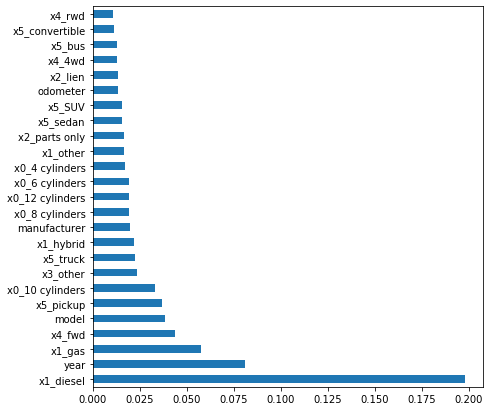

In [281]:
feat_importances.nlargest(25).plot(kind='barh',figsize=(7,7))

We tried Selecting important features obtained by Linear Regression and use those to train XGBoost model, which seems to lower the accuracy a bit.

In [110]:
pipe_rfe_xgregcv = make_pipeline(processing_pipe,
                                 RFECV(LinearRegression(), cv=5,n_jobs=-1), xg_reg)
np.mean(cross_val_score(pipe_rfe_xgregcv, X_train_val, y_train_val, cv=5))

0.7886444415173182

In [0]:
data['year'] = data['year'].astype(int)
data['odometer'] = data['odometer'].astype(int)
for i in categorical_columns:
  data[i] = data[i].astype('category')

In [0]:
data['age'] = data['year'] - 1985
data = data.drop(columns = 'year')

In [0]:
# randomly subsampling 
sample1 = data.sample(frac=0.5, random_state=1)
sample1.shape

# splitting the data into X (features) and y (i.e. label)
y = sample1[['price']] # label
X = sample1.drop(columns = ['price']) # features

# splitting the data into training, validation and testing
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state = 42)

In [0]:
data.dtypes

region            object
price              int64
manufacturer      object
model             object
condition       category
cylinders       category
fuel            category
odometer           int64
title_status    category
transmission    category
drive           category
size            category
type            category
paint_color     category
state             object
age                int64
dtype: object

In [0]:
cat_processing = make_pipeline(OneHotEncoder(handle_unknown = 'ignore'))
cont_processing = make_pipeline(PolynomialFeatures(degree=2), StandardScaler())
target_processing = make_pipeline(TargetEncoder(), StandardScaler())

preprocess = make_column_transformer(
    (target_processing, make_column_selector(dtype_include = 'object')),
    (cat_processing, make_column_selector(dtype_include = 'category')), remainder=cont_processing)

In [0]:
y_train_val = y_train_val.values
y_train_val = y_train_val.ravel()

In [0]:
pipe = make_pipeline(preprocess, DecisionTreeRegressor(max_depth = 5))

In [0]:
start_time = time.time()
pipe.fit(X_train_val, y_train_val)
pred = pipe.predict(X_test)
print(pipe.score(X_test,y_test))
print("--- %s seconds ---" % (time.time() - start_time))

0.5598398554129603
--- 2.840186357498169 seconds ---


In [0]:
preprocess.named_transformers_

{'pipeline-1': Pipeline(memory=None,
          steps=[('targetencoder',
                  TargetEncoder(cols=['region', 'manufacturer', 'model',
                                      'state'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value', min_samples_leaf=1,
                                return_df=True, smoothing=1.0, verbose=0)),
                 ('standardscaler',
                  StandardScaler(copy=True, with_mean=True, with_std=True))],
          verbose=False), 'pipeline-2': Pipeline(memory=None,
          steps=[('onehotencoder',
                  OneHotEncoder(categories='auto', drop=None,
                                dtype=<class 'numpy.float64'>,
                                handle_unknown='ignore', sparse=True))],
          verbose=False), 'remainder': Pipeline(memory=None,
          steps=[('polynomialfeatures',
                  PolynomialFeatures(degree=2, include_bias=True,
 

In [0]:
l2 = preprocess.named_transformers_['pipeline-2']['onehotencoder'].get_feature_names()
l1 = preprocess.named_transformers_['pipeline-1']['targetencoder'].get_feature_names()
l3 = preprocess.named_transformers_['remainder']['polynomialfeatures'].get_feature_names()

In [0]:
X_train_val.columns

Index(['region', 'manufacturer', 'model', 'condition', 'cylinders', 'fuel',
       'odometer', 'title_status', 'transmission', 'drive', 'size', 'type',
       'paint_color', 'state', 'age'],
      dtype='object')

Top features using Feature Importances from Decision Tree Regressor model

In [42]:
features = list(l1)
features.extend(l2)
features.extend(l3)
coef = pipe[1].feature_importances_
t1 = [(i,j) for i, j in zip(coef, features)]
t2 = sorted(t1, key = lambda a: abs(a[0]), reverse = True)
t2[:5]

[(0.4648291621361818, 'model'),
 (0.4388180551704728, 'x1^2'),
 (0.04087845053092869, 'x1'),
 (0.02700873564977228, 'x2_diesel'),
 (0.014503134242888526, 'x0^2')]

In [0]:
cat_processing = make_pipeline(OneHotEncoder(handle_unknown = 'ignore'))
cont_processing = make_pipeline(PolynomialFeatures(interaction_only=True), StandardScaler())
target_processing = make_pipeline(TargetEncoder(), StandardScaler())

preprocess = make_column_transformer(
    (target_processing, make_column_selector(dtype_include = 'object')),
    (cat_processing, make_column_selector(dtype_include = 'category')), remainder=cont_processing)

In [0]:
y_train_val = y_train_val.values
y_train_val = y_train_val.ravel()

In [0]:
pipe = make_pipeline(preprocess, DecisionTreeRegressor(max_depth = 5))

In [0]:
start_time = time.time()
pipe.fit(X_train_val, y_train_val)
pred = pipe.predict(X_test)
print(pipe.score(X_test,y_test))
print("--- %s seconds ---" % (time.time() - start_time))

0.5598398554129603
--- 2.840186357498169 seconds ---


In [0]:
preprocess.named_transformers_

{'pipeline-1': Pipeline(memory=None,
          steps=[('targetencoder',
                  TargetEncoder(cols=['region', 'manufacturer', 'model',
                                      'state'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value', min_samples_leaf=1,
                                return_df=True, smoothing=1.0, verbose=0)),
                 ('standardscaler',
                  StandardScaler(copy=True, with_mean=True, with_std=True))],
          verbose=False), 'pipeline-2': Pipeline(memory=None,
          steps=[('onehotencoder',
                  OneHotEncoder(categories='auto', drop=None,
                                dtype=<class 'numpy.float64'>,
                                handle_unknown='ignore', sparse=True))],
          verbose=False), 'remainder': Pipeline(memory=None,
          steps=[('polynomialfeatures',
                  PolynomialFeatures(degree=2, include_bias=True,
 

In [0]:
l2 = preprocess.named_transformers_['pipeline-2']['onehotencoder'].get_feature_names()
l1 = preprocess.named_transformers_['pipeline-1']['targetencoder'].get_feature_names()
l3 = preprocess.named_transformers_['remainder']['polynomialfeatures'].get_feature_names()

In [0]:
X_train_val.columns

Index(['region', 'manufacturer', 'model', 'condition', 'cylinders', 'fuel',
       'odometer', 'title_status', 'transmission', 'drive', 'size', 'type',
       'paint_color', 'state', 'age'],
      dtype='object')

In [0]:
features = list(l1)
features.extend(l2)
features.extend(l3)
coef = pipe[1].feature_importances_
t1 = [(i,j) for i, j in zip(coef, features)]
t2 = sorted(t1, key = lambda a: abs(a[0]), reverse = True)
t2[:5]

[(0.47969650570140154, 'x1'),
 (0.4648291621361818, 'model'),
 (0.02700873564977228, 'x2_diesel'),
 (0.017077757932763525, 'x0'),
 (0.011387838579880879, 'region')]

In [0]:
X1 = preprocess.fit_transform(X_train_val, y_train_val)

In [0]:
print(X1.shape)
X1 = X1.todense()
X1_preprocessed = pd.DataFrame(X1, columns = features)

(193196, 69)

##### Method 1 - Using Recursive Feature Elimination using Linear Regression

In [0]:
# Recursive Feature Elimination using Linear Regression
from sklearn.feature_selection import RFECV
rfe = RFECV(LinearRegression(), cv=10, min_features_to_select=1)
rfe.fit(X1, y_train_val)
print(rfe.support_)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True False  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True False  True  True  True]


In [0]:
# feature importances by RFECV
print(X1_preprocessed.columns[rfe.support_])
print(rfe.ranking_)

Index(['x0_excellent', 'x0_fair', 'x0_good', 'x0_like new', 'x0_new',
       'x0_salvage', 'x1_10 cylinders', 'x1_12 cylinders', 'x1_3 cylinders',
       'x1_4 cylinders', 'x1_5 cylinders', 'x1_6 cylinders', 'x1_8 cylinders',
       'x1_other', 'x2_diesel', 'x2_electric', 'x2_gas', 'x2_hybrid',
       'x2_other', 'x3_clean', 'x3_lien', 'x3_missing', 'x3_parts only',
       'x3_rebuilt', 'x3_salvage', 'x4_automatic', 'x4_manual', 'x4_other',
       'x5_4wd', 'x5_fwd', 'x5_rwd', 'x6_compact', 'x6_full-size',
       'x6_mid-size', 'x6_sub-compact', 'x7_SUV', 'x7_bus', 'x7_convertible',
       'x7_coupe', 'x7_hatchback', 'x7_mini-van', 'x7_offroad', 'x7_other',
       'x7_pickup', 'x7_sedan', 'x7_truck', 'x7_van', 'x7_wagon', 'x8_Unknown',
       'x8_blue', 'x8_brown', 'x8_custom', 'x8_green', 'x8_grey', 'x8_orange',
       'x8_purple', 'x8_red', 'x8_silver', 'x8_white', 'x8_yellow', 'region',
       'manufacturer', 'model', 'state', 'x0', 'x1', 'x0 x1'],
      dtype='object')
[1 1 1 1 1 1

In [4]:
# Recursive Feature Selection using XGBoost taking a lot of time
from sklearn.feature_selection import RFECV
rfe = RFECV(xgb, cv=5)
rfe.fit(X1, y_train_val)
print(rfe.support_)
print(X1_preprocessed.columns[rfe.support_])

We tried getting features importance using RFECV for XGBoost model but it took a lot of time and hence we didn't continue with that further.

##### Method 2 - Using Recursive Feature Elimination using Decision Tree

In [45]:
xgreg = XGBRegressor(alpha = 0.1, 
                   colsample_bytree = 0.5,
                   learning_rate = 0.1,
                   max_depth = 25,
                   n_estimators = 50,
                   n_jobs = -1)

In [48]:
pipe_rfe_xgregcv = make_pipeline(preprocess,
                                 RFECV(DecisionTreeRegressor(), cv=5,n_jobs=-1), 
                                 xgreg)
np.mean(cross_val_score(pipe_rfe_xgregcv, X_train_val, y_train_val, cv=5))

0.5838623684153589

##### Method 3 - Finding important features using SelectFromModel using XGBoost and LassoCV

In [0]:
xgb = XGBRegressor(objective = 'reg:squarederror',
                   alpha = 0.1, 
                   colsample_bytree = 0.5,
                   learning_rate = 0.1,
                   max_depth = 25,
                   n_estimators = 50,
                   n_jobs = -1)

In [0]:
select_xgboost = SelectFromModel(xgb, threshold=1e-2)
select_xgboost.fit(X1, y_train_val)
print(select_xgboost.transform(X1).shape)

(193196, 20)


In [0]:
X1_xgboost = select_xgboost.transform(X1)
pipe_xgb = make_pipeline(DecisionTreeRegressor())
print(np.mean(cross_val_score(pipe_xgb, X1_xgboost, y_train_val, cv=10)))
print(np.mean(cross_val_score(pipe_xgb, X1, y_train_val, cv=10)))

0.6230376730226608
0.5942005347243712


We can see here that if we use only the top 20 features from SelectFromModel and use DecisionTreeRregressor on it, we get a better result than using all the features together. 
Next, we will run our XGBoost model on the top 20 features and see what happens.

In [0]:
print(np.mean(cross_val_score(xgb, X1_xgboost, y_train_val, cv=5)))

0.7812960221061896


Now, lets select features using LassoCV and then use those features to run our XGBoost model. 

In [0]:
select_lassocv = SelectFromModel(LassoCV(), threshold=1e-4)
select_lassocv.fit(X1, y_train_val)
X1_lasso = select_lassocv.transform(X1)
print(select_lassocv.transform(X1).shape)

(193196, 39)


In [0]:
print(np.mean(cross_val_score(xgb, X1_lasso, y_train_val, cv=5)))

0.803380444684214


We can see that if we select the important features using LassoCV and then apply XGBoost on those important feautre, we get a better model

In [0]:
pipe_lassocv = make_pipeline(select_lassocv, RidgeCV())
all_features = make_pipeline(RidgeCV())
print(np.mean(cross_val_score(pipe_lassocv, X1, y_train_val, cv=10)))
print(np.mean(cross_val_score(all_features, X1, y_train_val, cv=10)))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expec

0.5925153093067441
0.5931984748529692


Next, we tried using Sequential Feature Selector on Linear Regression to get the most important features.

##### Method 4 - Finding important features using Sequential Feature Selector on Linear Regression and on XGBoost


In [0]:
sfs = SequentialFeatureSelector(LinearRegression(), forward=False, k_features=7)
sfs.fit(X1, y_train_val)

print(sfs.k_feature_idx_)
print(X1_preprocessed.columns[np.array(sfs.k_feature_idx_)])

print(sfs.k_score_)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


(11, 12, 16, 61, 63, 67, 68)
Index(['x1_6 cylinders', 'x1_8 cylinders', 'x2_gas', 'region', 'model', 'x1',
       'x0 x1'],
      dtype='object')
0.5654248460648045


In [0]:
# tried the same for XGBoost, but its taking a lot of time
sfs = SequentialFeatureSelector(xgb, forward=False, k_features=7)
sfs.fit(X1, y_train_val)

print(sfs.k_feature_idx_)
print(X1_preprocessed.columns[np.array(sfs.k_feature_idx_)])

print(sfs.k_score_)

We tried getting features importance using Sequential Feature Selector for XGBoost model but it took a lot of time and hence we didn't continue with that further.

- As we can see that we are getting a very good score after selecting features from LassoCV and then running our final XGBoost model with the tunes hyper parameters. Thus, we will now fit our LassoCV model on the entire dataset and report our score using the tuned XGBoost model on test data with only the features we get from LassoCV.

### Using LassoCV and SelectFromModel to select the important features and use those features to train the XGBoost model and get the R^2 score for test set

In [0]:
# splitting the data into X (features) and y (i.e. label)
y = data[['price']] # label
X = data.drop(columns = ['price']) # features

# splitting the data into training, validation and testing
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state = 42)

# preprocess the X_train and X_test
X1 = preprocess.fit_transform(X_train_val, y_train_val)
X_test_processed = preprocess.transform(X_test)

In [0]:
select_lassocv = SelectFromModel(LassoCV(), threshold=1e-4)
select_lassocv.fit(X1, y_train_val)
X1_lasso = select_lassocv.transform(X1)
print(select_lassocv.transform(X1).shape)

(386392, 41)


In [0]:
X_test_processed = select_lassocv.transform(X_test_processed)
start_time = time.time()
xgb.fit(X1_lasso, y_train_val)
pred = xgb.predict(X_test_processed)
print(xgb.score(X_test_processed,y_test))
print("--- %s seconds ---" % (time.time() - start_time))

0.8447703588643329
--- 106.15354466438293 seconds ---


We can clearly see that when we did feature selection using LassoCV on the entire dataset, we increase the r-sqaured score of our final model that is XGBoost by 0.1.

# Explainable model

To make an explainable model, we will use only the top 6 features that we found from the different feature selection techniques above.

In [0]:
# selecting the top features from different feature selection techniques
important_features = ['model', 'region', 'odometer', 'age', 'fuel', 'price']
small_data = data[important_features]
small_data.head()

,model,region,odometer,age,fuel,price
0,golf r,salt lake city,63500,27,gas,17899
1,f-150,salt lake city,10,31,gas,8990
3,f-150,salt lake city,10,31,gas,8990
5,Unknown,salt lake city,120057,24,gas,13999
6,f-350,salt lake city,95484,32,diesel,34500


In [0]:
small_data.dtypes

model         object
region        object
odometer       int64
age            int64
fuel        category
price          int64
dtype: object

In [0]:
# splitting the data into X (features) and y (i.e. label)
y = small_data[['price']] # label
X = small_data.drop(columns = ['price']) # features

# splitting the data into training, validation and testing
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state = 42)

In [0]:
# simple preprocessing to make an explainable model
cat_processing = make_pipeline(OneHotEncoder(handle_unknown = 'ignore'))
cont_processing = make_pipeline(StandardScaler())
target_processing = make_pipeline(TargetEncoder(), StandardScaler())

simple_preprocess = make_column_transformer(
    (target_processing, make_column_selector(dtype_include = 'object')),
    (cat_processing, make_column_selector(dtype_include = 'category')), remainder=cont_processing)

In [0]:
pipe = make_pipeline(simple_preprocess, LinearRegression())
start_time = time.time()
pipe.fit(X_train_val, y_train_val)
pred = pipe.predict(X_test)
print(pipe.score(X_test,y_test))
print("--- %s seconds ---" % (time.time() - start_time))

0.5581009056105071
--- 1.1101269721984863 seconds ---


When we ran a linear model on the entire dataset with all the features, we get a r-squared score of approximately 0.55 which is the same as above (when we select only the important features).

In [0]:
# finding the coefficient after Linear Regression
l2 = simple_preprocess.named_transformers_['pipeline-2']['onehotencoder'].get_feature_names()
l1 = simple_preprocess.named_transformers_['pipeline-1']['targetencoder'].get_feature_names()
l3 = ['odometer', 'age']

In [0]:
features = list(l1)
features.extend(l2)
features.extend(l3)
coef = pipe[1].coef_
t1 = [(i,j) for i, j in zip(coef, features)]
# t2 = sorted(t1, key = lambda a: abs(a[0]), reverse = True)
t1

[(4121.772982430498, 'model'),
 (1041.710251508221, 'region'),
 (3932.0075692318596, 'x0_diesel'),
 (-2500.687733405713, 'x0_electric'),
 (-446.56012020231617, 'x0_gas'),
 (-1247.3486026821213, 'x0_hybrid'),
 (262.58888705828673, 'x0_other'),
 (-798.6072913450822, 'odometer'),
 (3100.590371221654, 'age')]

In [0]:
# converting y to numpy for random forest regression
y_train_val = y_train_val.values
y_train_val = y_train_val.ravel()

pipe = make_pipeline(simple_preprocess, DecisionTreeRegressor(max_depth = 5))
start_time = time.time()
pipe.fit(X_train_val, y_train_val)
pred = pipe.predict(X_test)
print(pipe.score(X_test,y_test))
print("--- %s seconds ---" % (time.time() - start_time))

0.5704241328345019
--- 1.8191964626312256 seconds ---


 We also tried building XGBoost model on whole dataset with the selected features but it gave worse R^2 as compared to the normal. We tried this to see if our explainable model was as good as the original model but comparing a normal decision tree with the XGBoost trained on whole dataset is too unrealistic when we already know that the XGBoost is a complex model and would generalize in a better way.
 
So to compare the performance keeping in mind the features we took and the performance of the explainable small decison tree was neerly same as XGBoost trained using the selected features(in fact greater than 0.1 as compared to XGBoost).

In [0]:
X2 = simple_preprocess.fit_transform(X_train_val, y_train_val)

In [0]:
l2 = simple_preprocess.named_transformers_['pipeline-2']['onehotencoder'].get_feature_names()
l1 = simple_preprocess.named_transformers_['pipeline-1']['targetencoder'].get_feature_names()
l3 = ['odometer', 'age']

In [0]:
features = list(l1)
features.extend(l2)
features.extend(l3)
coef = pipe[1].feature_importances_
t1 = [(i,j) for i, j in zip(coef, features)]
t2 = sorted(t1, key = lambda a: abs(a[0]), reverse = True)
t2[:5]

[(0.5883857842065066, 'model'),
 (0.3621827294137506, 'age'),
 (0.022336882768516322, 'x0_diesel'),
 (0.013324121082545982, 'odometer'),
 (0.011259935869855039, 'region')]

In [0]:
features

['model',
 'region',
 'x0_diesel',
 'x0_electric',
 'x0_gas',
 'x0_hybrid',
 'x0_other',
 'odometer',
 'age']

In [0]:
#X2 = X2.todense()
X2_df = pd.DataFrame(X2, columns = features)

In [0]:
reg = DecisionTreeRegressor(max_leaf_nodes = 5)
reg = reg.fit(X2_df, y_train_val)

In [30]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin'

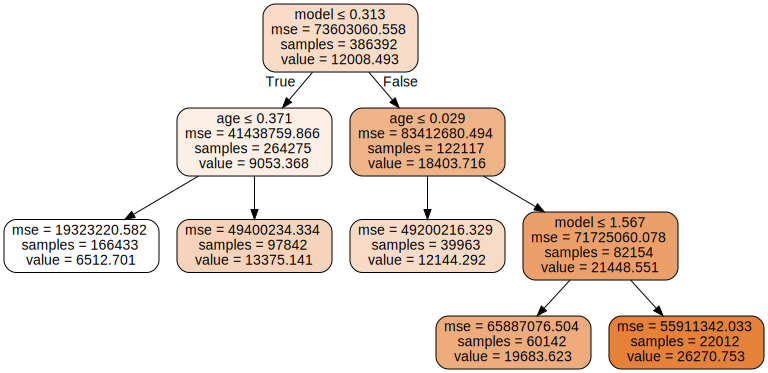

In [31]:
dot_data = tree.export_graphviz(reg, out_file=None, 
                      feature_names=features,  
                      filled=True, rounded=True,  
                      special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

Conclusion -
Using the coefficients from Linear Regression and feature importances from Decision Tree, we can clearly see that our most important features are model, age, region and diesel cars (basically fuel). 
We can see that model is positively correlated with price whereas age is negatively correlated (the way we have defined age is, that more the value of the age newer the car, thus, newer the car more the price. 
Another finding is that diesel cars are most expensive on Craigslist while compared to other types of fuel cars. 

# Final Model 

If someone asks us what were the main findings of this entire exercise, we would like to summarise the entire exercise below. 
If someone wants to work on this dataset then he/she should follow the following steps based on our findings - 
1. Most important was exploring the dataset and preprocessing the data. 
  1. There are many outliers in the dataset, so remove all the outliers from features like price, odometer, year etc. 
  2. There were a lot of missing values, so need to carry out missing value analysis by imputing the continuous features with the mean of the feature and categorical features with either the mode of the feature or by introducing a new column - Unknown for the missing data. 
  3. Convert the continuous columns to int/float
  4. Make sure to delete columns like id so that they do not leak information about the target variable
2. Once we are done with this, we need more in depth data preprocessing - 
  1. One hot encode the categorical columns
  2. Target encode the categorical columns that have a lot of categories like model that has over 30,000 categories
  3. We also tried Polynomial feature expansion on our continuous features that gave us a better result
  4. Lastly, make sure to scale your data
3. Now we will start building our models. We have tried a variety of models but the best one was XGBoost. We also performed Grid Search Cross Validation to tune our hyper-parameters of XGBoost. 
The other models one can try from the ones we have tried and reported the cross validation score are - 
  1. Linear Models - Linear Regression, Lasso and Ridge
  2. Tree Based Models - Decision Tree, Random Forest, Gradient Boosting and XGBoost
4. Feature Selection - As we had a lot of features we wanted to understand which features are important and maybe select the best features to get a better accuracy. The different techniques we used here are -
  1. Recursive Feature Selection using Linear Regression and Decision Tree Regressor 
  2. SelectFromModel using LassoCV and XGBoost
  3. Sequential Feature Selection using Linear Regression. We tried this on XGBoost but it was taking a lot of time to run 
  4. Using feature importances from the Decision Tree and XGBoost models
The best one turned out to be selecitng features using LassoCV, that selected 41 out of the 69 features. Then, we used only these features to run our final XGBoost model. This gave us a better score than using all the features. 